
# 🏡 House Price Prediction (ML Project)

This notebook builds a regression model to predict house prices using the Kaggle "House Prices - Advanced Regression Techniques" dataset.

## Goals

- Perform exploratory data analysis (EDA)
- Handle missing values and preprocess data
- Build and compare multiple regression models:
  - Linear Regression
  - Random Forest
  - Gradient Boosting / XGBoost (optional)
- Evaluate models using RMSE and R²
- Interpret model predictions using SHAP (feature importance)

---

---



In [ ]:
# Basic imports
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Model and preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Metrics
from sklearn.metrics import mean_squared_error, r2_score

# To ignore some warnings
import warnings
warnings.filterwarnings("ignore")

# Optional: SHAP for explainability (install via: pip install shap)
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not installed. Run `pip install shap` if you want model explanations.")


In [ ]:
# Path to dataset (adjust if needed)
data_path = "/content/house_prices.csv.csv"

df = pd.read_csv(data_path)
print("Shape of dataset:", df.shape)
df.head()


Shape of dataset: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


## 🔍 Quick Data Overview

We'll:

- Look at basic info and summary statistics
- Check missing values
- Separate target (`SalePrice`) from features


In [ ]:
# Basic info
df.info()
# Summary stats
df.describe().T.head(15)
# Percentage of missing values per column
missing_percent = df.isnull().mean().sort_values(ascending=False)
missing_percent[missing_percent > 0].head(20)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

,0
PoolQC,0.995205
MiscFeature,0.963014
Alley,0.937671
Fence,0.807534
MasVnrType,0.597260
FireplaceQu,0.472603
LotFrontage,0.177397
GarageQual,0.055479
GarageFinish,0.055479
GarageType,0.055479


## 📊 EDA: Target & Feature Distributions

We’ll:

- Look at the distribution of `SalePrice`
- Check correlations with numeric features
- Visualize a few important relationships


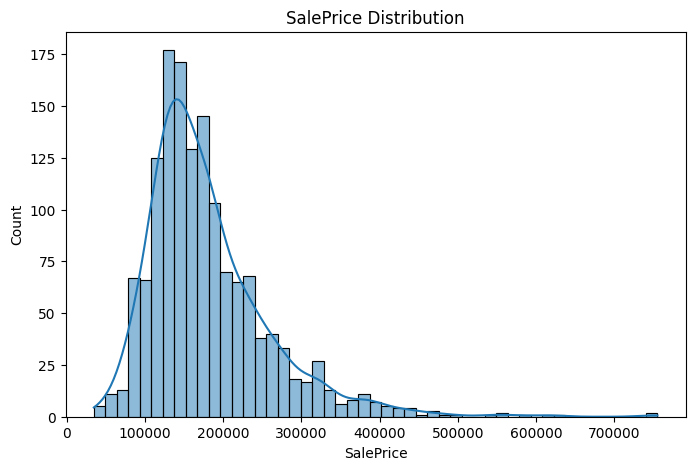

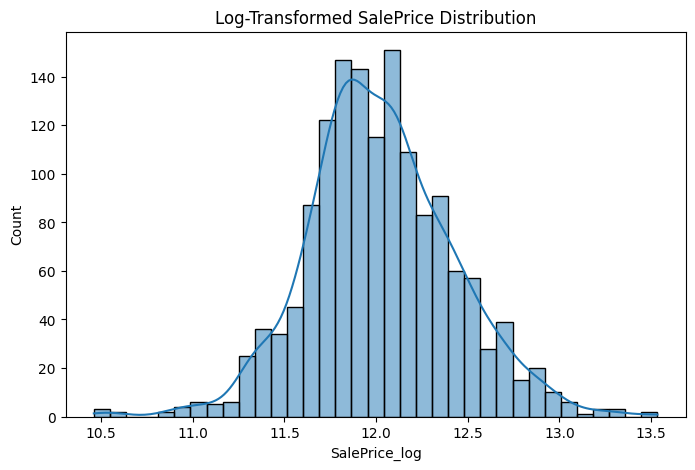

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(df["SalePrice"], kde=True)
plt.title("SalePrice Distribution")
plt.show()

# Optional: log-transform target to reduce skew
df["SalePrice_log"] = np.log1p(df["SalePrice"])

plt.figure(figsize=(8, 5))
sns.histplot(df["SalePrice_log"], kde=True)
plt.title("Log-Transformed SalePrice Distribution")
plt.show()


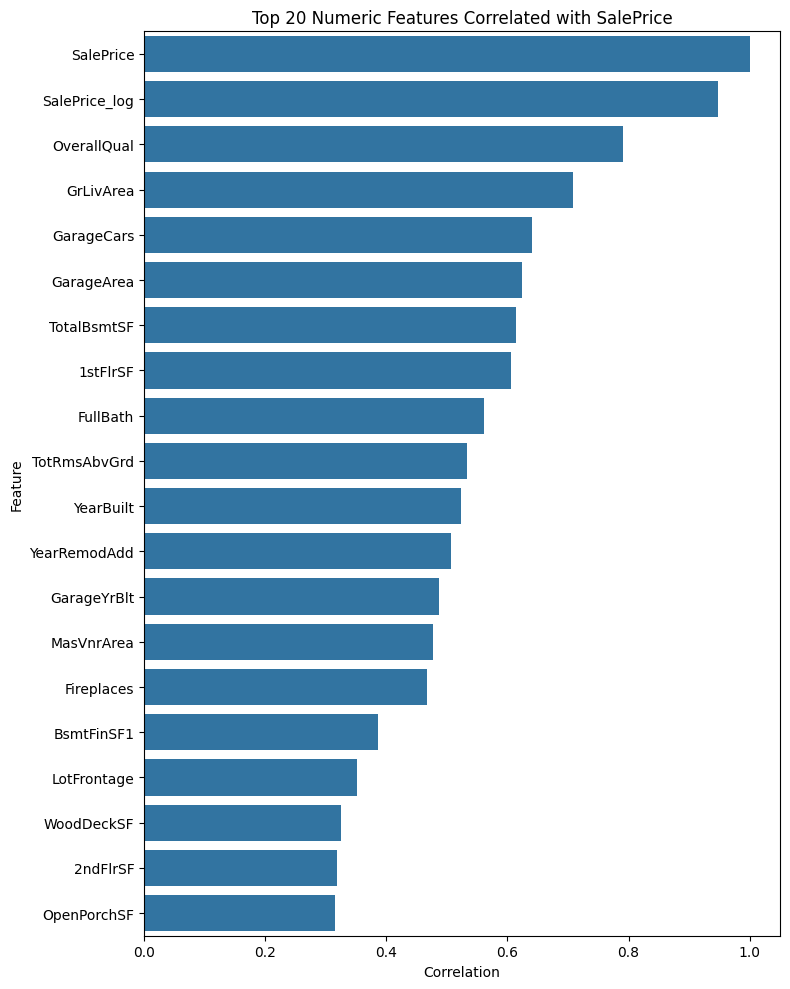

In [ ]:
numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()

# Compute correlation with target
corr_with_target = df[numeric_features].corr()["SalePrice"].sort_values(ascending=False)
corr_with_target.head(15)
plt.figure(figsize=(8, 10))
sns.barplot(x=corr_with_target.head(20), y=corr_with_target.head(20).index)
plt.title("Top 20 Numeric Features Correlated with SalePrice")
plt.xlabel("Correlation")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

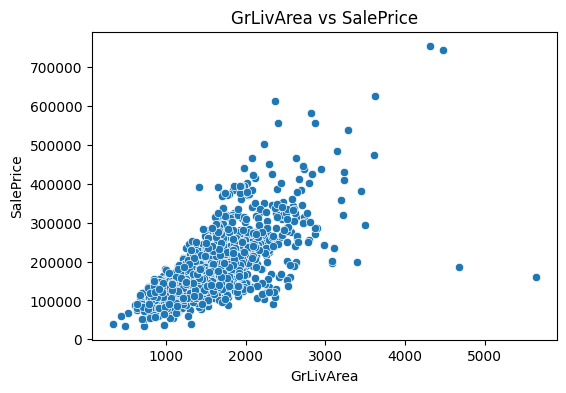

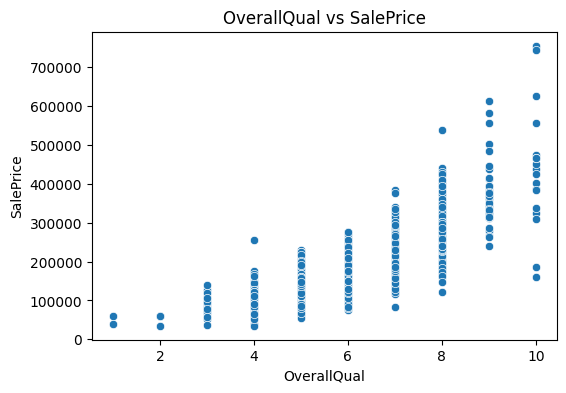

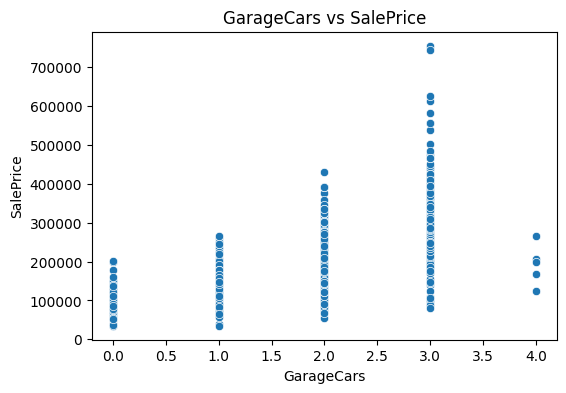

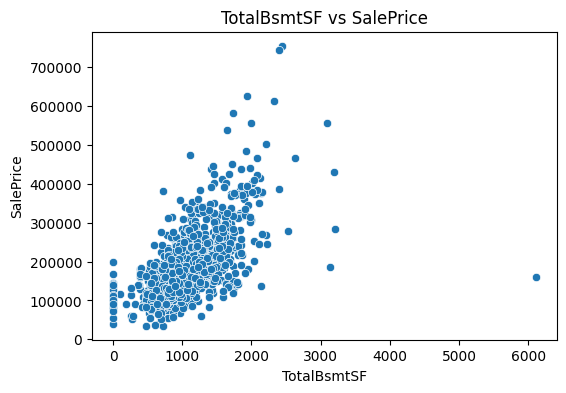

In [ ]:
important_features = ["GrLivArea", "OverallQual", "GarageCars", "TotalBsmtSF"]

for col in important_features:
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=df[col], y=df["SalePrice"])
    plt.title(f"{col} vs SalePrice")
    plt.show()


## 🧱 Train/Test Split & Preprocessing Plan

- Target: `SalePrice` (or `SalePrice_log` if using log target)
- Features: all columns except ID and target(s)
- Split into train and test sets
- Build preprocessing pipelines:
  - Numeric: impute missing values, scale
  - Categorical: impute missing values, one-hot encode


In [ ]:
# Drop ID-like column if present
if "Id" in df.columns:
    df = df.drop(columns=["Id"])

# Choose whether to use log-transformed target
USE_LOG_TARGET = True

if USE_LOG_TARGET:
    target_col = "SalePrice_log"
else:
    target_col = "SalePrice"

X = df.drop(columns=["SalePrice", "SalePrice_log"])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.shape, X_test.shape


((1168, 79), (292, 79))

In [ ]:
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)


## 🧮 Model 1: Linear Regression (Baseline)

We'll:

- Wrap preprocessing + model in a single pipeline
- Evaluate using RMSE and R²
- This serves as a simple baseline


In [ ]:
linreg_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LinearRegression())
])

linreg_model.fit(X_train, y_train)

y_pred_train = linreg_model.predict(X_train)
y_pred_test = linreg_model.predict(X_test)

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

print("Linear Regression Performance:")
print("Train RMSE:", rmse(y_train, y_pred_train))
print("Test RMSE:", rmse(y_test, y_pred_test))
print("Train R²:", r2_score(y_train, y_pred_train))
print("Test R²:", r2_score(y_test, y_pred_test))


Linear Regression Performance:
Train RMSE: 0.0919978460506614
Test RMSE: 0.12808647408095458
Train R²: 0.9444800022315827
Test R²: 0.9120837150773479


## 🌳 Model 2 & 3: Random Forest & Gradient Boosting

Tree-based models often perform better on tabular data.

We will:

- Train `RandomForestRegressor`
- Train `GradientBoostingRegressor`
- Compare performance to Linear Regression


In [ ]:
rf_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        n_jobs=-1
    ))
])

gbr_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", GradientBoostingRegressor(
        random_state=42
    ))
])

models = {
    "Linear Regression": linreg_model,
    "Random Forest": rf_model,
    "Gradient Boosting": gbr_model
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    results.append({
        "model": name,
        "rmse": rmse(y_test, y_pred),
        "r2": r2_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results)
results_df.sort_values(by="rmse")


,model,rmse,r2
0,Linear Regression,0.128086,0.912084
2,Gradient Boosting,0.138175,0.897689
1,Random Forest,0.146033,0.885722


## ⚡ Optional: XGBoost / LightGBM

These often give strong performance on tabular data.

You can install:

```bash
pip install xgboost lightgbm


In [ ]:
!pip install xgboost lightgbm

In [ ]:


### 🟦 Cell 18 — (Code) Optional XGBoost Model

try:
    from xgboost import XGBRegressor

    xgb_model = Pipeline(steps=[
        ("preprocess", preprocessor),
        ("model", XGBRegressor(
            n_estimators=500,
            learning_rate=0.05,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=42,
            n_jobs=-1
        ))
    ])

    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)

    results.append({
        "model": "XGBoost",
        "rmse": rmse(y_test, y_pred_xgb),
        "r2": r2_score(y_test, y_pred_xgb)
    })

    results_df = pd.DataFrame(results)
    results_df.sort_values(by="rmse")
except ImportError:
    print("XGBoost not installed. Run `pip install xgboost` to enable this cell.")


## 🏆 Pick the Best Model

We’ll select the model with lowest RMSE on the test set and use it for interpretation.


In [ ]:
results_df = pd.DataFrame(results)
results_df_sorted = results_df.sort_values(by="rmse")
results_df_sorted
best_model_name = results_df_sorted.iloc[0]["model"]
best_model = models.get(best_model_name, None)

print("Best model based on RMSE:", best_model_name)

Best model based on RMSE: Linear Regression


## 🔎 Model Explainability with SHAP

We’ll:

- Use SHAP values to see which features contribute most to predictions
- Helps you write strong resume bullet points about interpretability

> Note: Works best with tree-based models (Random Forest, Gradient Boosting, XGBoost).


In [ ]:
if not SHAP_AVAILABLE:
    print("SHAP not installed. Run `pip install shap` and re-run this cell.")
else:
    # We need the preprocessed training data and underlying model
    # This works best with tree-based models
    if best_model_name not in ["Random Forest", "Gradient Boosting", "XGBoost"]:
        print("For better SHAP explanations, consider choosing a tree-based model.")

    # Get the ColumnTransformer and underlying model
    preprocess = best_model.named_steps["preprocess"]
    model = best_model.named_steps["model"]

    # Fit the preprocessor and transform training data
    X_train_transformed = preprocess.fit_transform(X_train)

    # SHAP explainer
    try:
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X_train_transformed)

        # Get feature names after preprocessing
        # numeric + onehot categorical
        ohe = preprocess.named_transformers_["cat"].named_steps["onehot"]
        cat_feature_names = ohe.get_feature_names_out(categorical_features)
        feature_names = np.concatenate([numeric_features, cat_feature_names])

        shap.summary_plot(shap_values, features=X_train_transformed, feature_names=feature_names)
    except Exception as e:
        print("Error generating SHAP values:", e)
        print("This can happen for some model types or SHAP versions.")


For better SHAP explanations, consider choosing a tree-based model.
Error generating SHAP values: Model type not yet supported by TreeExplainer: <class 'sklearn.linear_model._base.LinearRegression'>
This can happen for some model types or SHAP versions.


## 🔁 Interpreting Predictions in Original Price Scale

If we trained on `log(SalePrice + 1)`, we should convert predictions back:

```python
y_pred_original = np.expm1(y_pred_log)


In [ ]:
# Take a few random examples
sample = X_test.sample(5, random_state=42)
sample_pred = best_model.predict(sample)

if USE_LOG_TARGET:
    sample_pred_price = np.expm1(sample_pred)
else:
    sample_pred_price = sample_pred

result_preview = sample.copy()
result_preview["PredictedPrice"] = sample_pred_price
result_preview

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,PredictedPrice
416,60,RL,74.0,7844,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,3,2006,WD,Normal,158249.565828
774,20,RL,110.0,14226,Pave,NaN,Reg,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,7,2007,New,Partial,302883.642740
1132,70,RM,90.0,9900,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,126730.827150
239,50,RL,52.0,8741,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,4,2010,WD,Normal,114908.376703
1092,50,RL,60.0,8400,Pave,NaN,Reg,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2008,WD,Normal,173318.723474


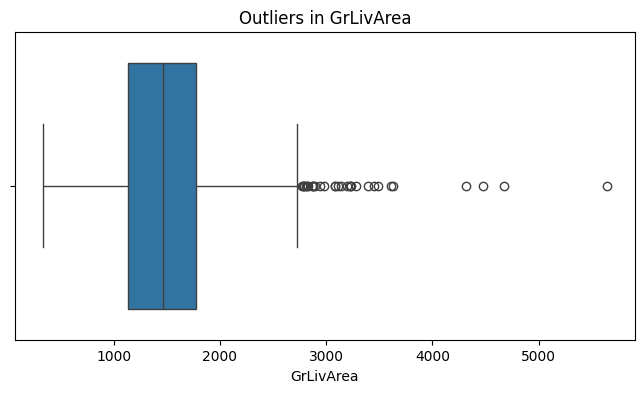

,SalePrice,GrLivArea
523,184750,4676
691,755000,4316
1182,745000,4476
1298,160000,5642


In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(x=df["GrLivArea"])
plt.title("Outliers in GrLivArea")
plt.show()

# Check extreme values
df[df["GrLivArea"] > 4000][["SalePrice", "GrLivArea"]]


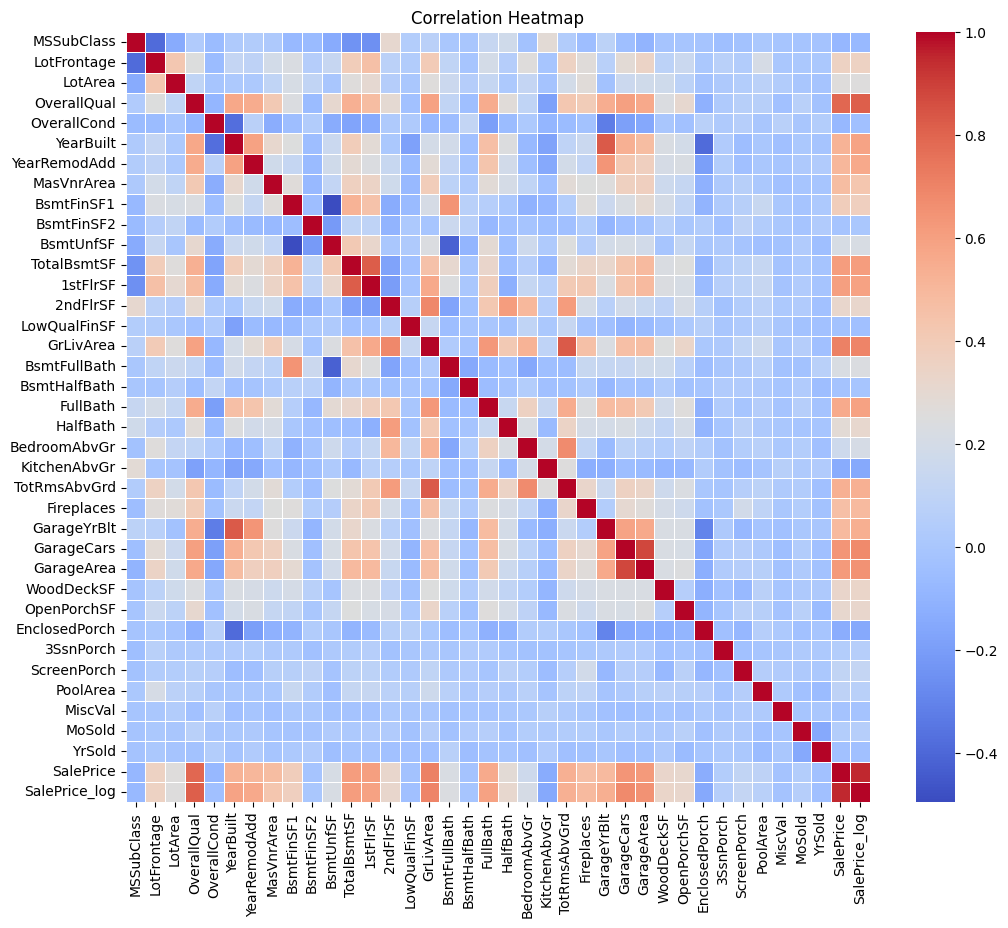

In [ ]:
plt.figure(figsize=(12,10))
corr = df.select_dtypes(include=['int64','float64']).corr()
sns.heatmap(corr, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()
